In [292]:
from Stable_SSM_EM import *
import numpy as np
import pandas as pd

from dateutil import tz
from astral import Astral
from pandas.tseries.offsets import *

from Utilities import *
from ModelTest import loadTestSets

# TODO
* Why is KTL $P_{\rm solar}$ so small???

In [3]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

# Load Feather data

In [287]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]

# Choose a network
df_feather_ktl = pd.read_csv("../raw_data/feather_data/%s.csv" % feather_wsns[0])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values
y_rad_raw = df_feather_ktl["solar_rad_8"].values
times = pd.to_datetime(df_feather_ktl["time"])

# Convert times to CA ones
utc_zone = tz.gettz("UTC")
ca_zone = tz.gettz("America/Los_Angeles")
times = np.array([t.replace(tzinfo=utc_zone).astimezone(ca_zone) for t in times])

# Get dawn/dusk times
astral = Astral()
astral.solar_depression = "civil"
city = astral["Sacramento"]

def get_dawn_dusk(ts):
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

# Full dataset

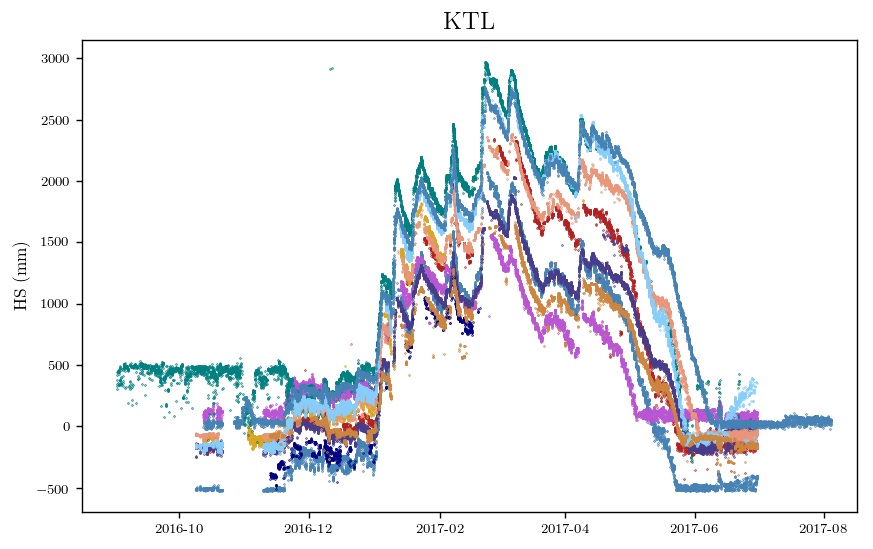

In [247]:
plt.figure(figsize=(8, 5))

ti, tf = 0, -1

for s, c in zip(range(y_sd_raw.shape[1]), colors):
    plt.plot(times[ti:tf], y_sd_raw[ti:tf, s], '.', markersize=0.5, color=c)

plt.xlim(times[ti], times[tf])
#plt.ylim(900, 2000)
plt.ylabel("HS (mm)")
plt.title("KTL")

plt.savefig("../presentations/figures/seasons_data.pdf", bbox_inches='tight')

# Issues overview

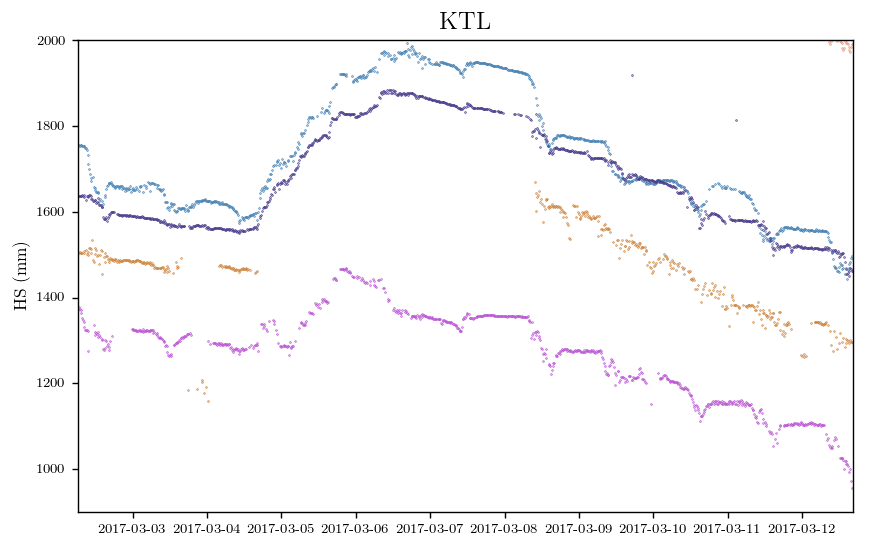

In [5]:
plt.figure(figsize=(8, 5))

ti, tf = 19000, 20000

for s, c in zip(range(y_sd_raw.shape[1]), colors):
    plt.plot(times[ti:tf], y_sd_raw[ti:tf, s], '.', markersize=0.75, color=c)

plt.xlim(times[ti], times[tf])
plt.ylim(900, 2000)
plt.ylabel("HS (mm)")
plt.title("KTL")

#plt.savefig("../presentations/figures/issues.pdf", bbox_inches='tight')

# Gap histogram

In [6]:
gapSizes = []

tStart = 10000

for series in y_sd_raw.T:
    curGapSizes = []
    
    curGapSize = 0
    # Loop over values in series
    for v in series[tStart:]:
        if np.isnan(v):
            curGapSize = curGapSize + 1
        elif curGapSize > 0:
            # Append current gap size if it's nonzero and a non-nan value was encountered
            gapSizes.append(curGapSize)
            curGapSize = 0
    
# Get total list of gap sizes for the whole dataset
gapSizes = np.asarray(gapSizes)

(0, 600)

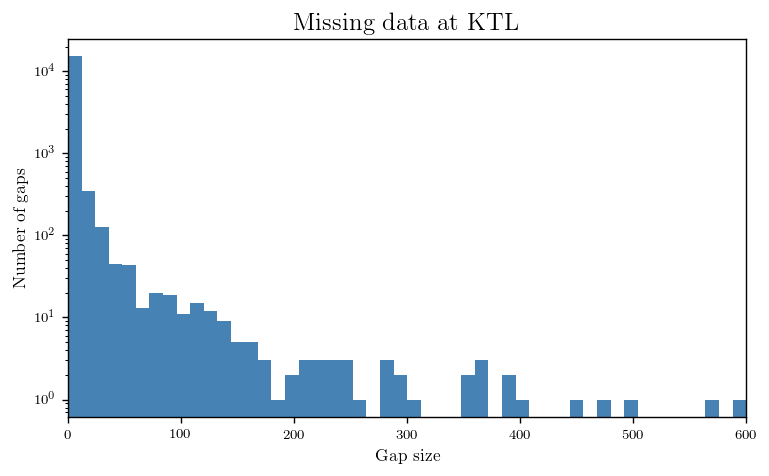

In [7]:
plt.figure(figsize=(7, 4))

plt.hist(gapSizes, bins=50, range=[0, 600])
plt.yscale("log")
plt.xlabel("Gap size")
plt.ylabel("Number of gaps")
plt.title("Missing data at KTL")
plt.xlim(0, 600)

#plt.savefig("../presentations/figures/gaps.pdf", bbox_inches='tight')

# Spurious summer HS oscillations

(736497.8958333334, 736499.9791666666)

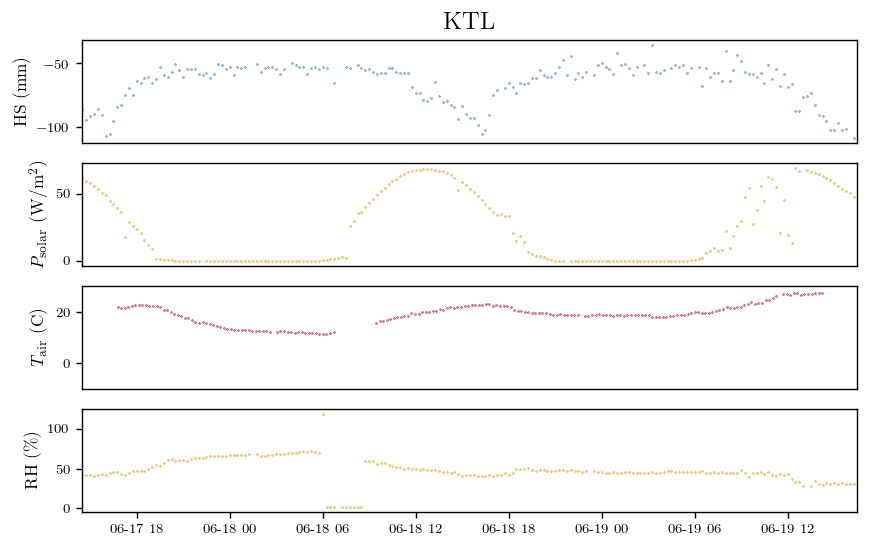

In [341]:
plt.figure(figsize=(8, 5))

ti, tf = 29300, 29500#30000

sensor = 6

plt.subplot(4, 1, 1)
plt.title("KTL")
plt.plot(times[ti:tf], y_sd_raw[ti:tf, sensor], '.', markersize=0.75, color=colors[0])
plt.ylabel(r"HS (mm)")
plt.xticks([])
plt.xlim(times[ti], times[tf])

plt.subplot(4, 1, 2)
plt.plot(times[ti:tf], y_rad_raw[ti:tf], '.', markersize=0.75, color=colors[2])
plt.ylabel(r"$P_{\rm solar}$ (W/m$^2$)")
plt.xlim(times[ti], times[tf])
plt.xticks([])

plt.subplot(4, 1, 3)
plt.plot(times[ti:tf], y_t_raw[ti:tf, sensor], '.', markersize=0.75, color=colors[1])
plt.ylabel(r"$T_{\rm air}$ (C)")
plt.xticks([])
plt.ylim(-10, 30)

plt.subplot(4, 1, 4)
plt.plot(times[ti:tf], y_rh_raw[ti:tf, sensor], '.', markersize=0.75, color=colors[2])
plt.ylabel(r"${\rm RH}$ (\%)")
plt.xlim(times[ti], times[tf])

#plt.savefig("../presentations/figures/summer_fluctuations.pdf", bbox_inches='tight')

# Kalman smoother

In [248]:
n_LF = 1
sensors = [7]#0, 1, 3, 4, 5, 6, 8, 9, 10]
max_it = 300

#ti, tf = 15040, 15240
#ti, tf = 19000, 19200
ti, tf = 16700, 16850

Y = y_sd_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)

#Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)
Y_hat = np.dot(Cs[0], X_hat) + np.dot(Ds[0], V)

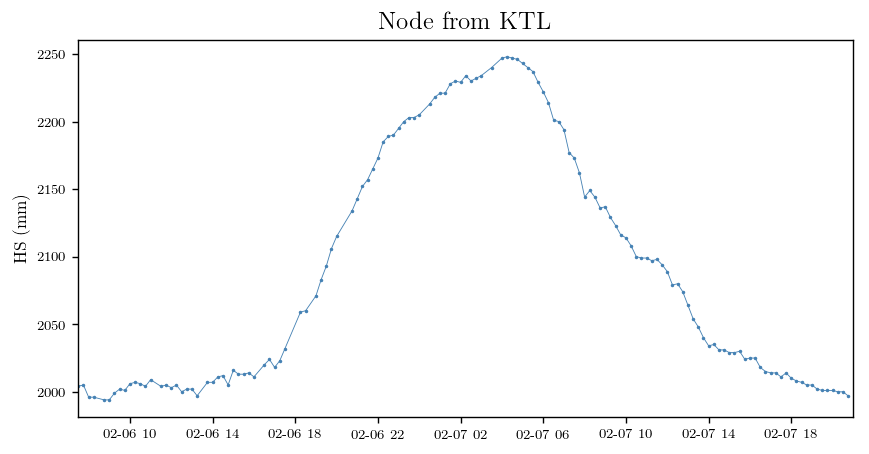

In [250]:
plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)), colors):
    plt.plot(times[ti:tf], Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(times[ti:tf], Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(times[ti], times[tf])
plt.ylabel("HS (mm)")
plt.title("Node from KTL")

plt.savefig("../presentations/figures/ks.pdf", bbox_inches='tight')

# Kalman smoother: trouble with missing data

In [171]:
n_LF = 1
sensors = [7]#, 1, 3, 4, 5, 6, 7, 8, 9, 10]
max_it = 20

ti, tf = 16700, 16850

Y = y_sd_raw[ti:tf, sensors].T

# Nan out some key data
Y_nand = Y.copy()
Y_nand[:, 65:95] = np.nan

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y_nand, U, V, ss, s_list, n_LF, max_it)

#Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)
Y_hat = np.dot(Cs[0], X_hat) + np.dot(Ds[0], V)

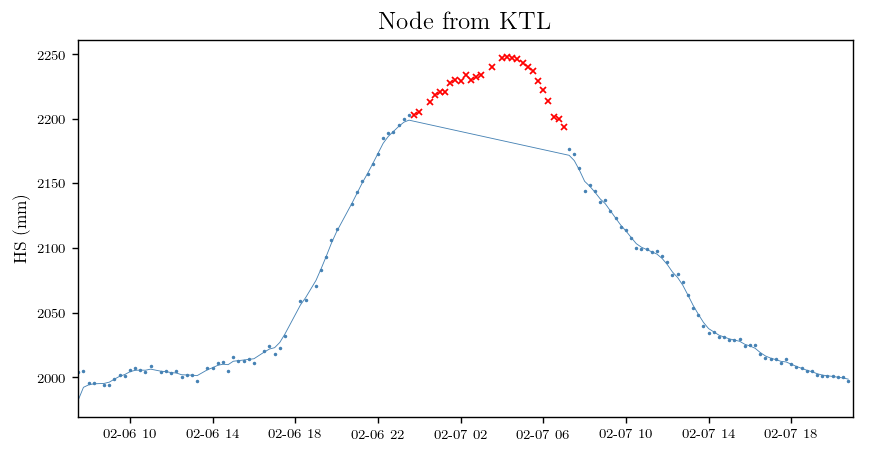

In [172]:
plt.figure(figsize=(8, 4))

# Mark removed points with xs
plt.plot(times[ti+65:tf-(150-95)], Y[0, 65:95], 'x', markersize=3.0, color="r")
plt.plot(times[ti:tf], Y_hat[0, :], '-', linewidth=0.5, color=c)
plt.plot(times[ti:tf], Y_nand[0, :], '.', markersize=2.0, color=c)

plt.xlim(times[ti], times[tf])
plt.ylabel("HS (mm)")
plt.title("Node from KTL")

#plt.savefig("../presentations/figures/ks_missing_data.pdf", bbox_inches='tight')

# EM example

In [223]:
n_LF = 2
sensors = [0, 4, 5, 6, 7]
max_it = 500

#ti, tf = 19000, 19150
ti, tf = 16700, 16850
Y = y_sd_raw[ti:tf, sensors].T

# Nan out some observations
Y_nand = Y.copy()
Y_nand[4, 65:95] = np.nan

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y_nand, U, V, ss, s_list, n_LF, max_it)

#Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)
Y_hat = np.dot(Cs[0], X_hat) + np.dot(Ds[0], V)

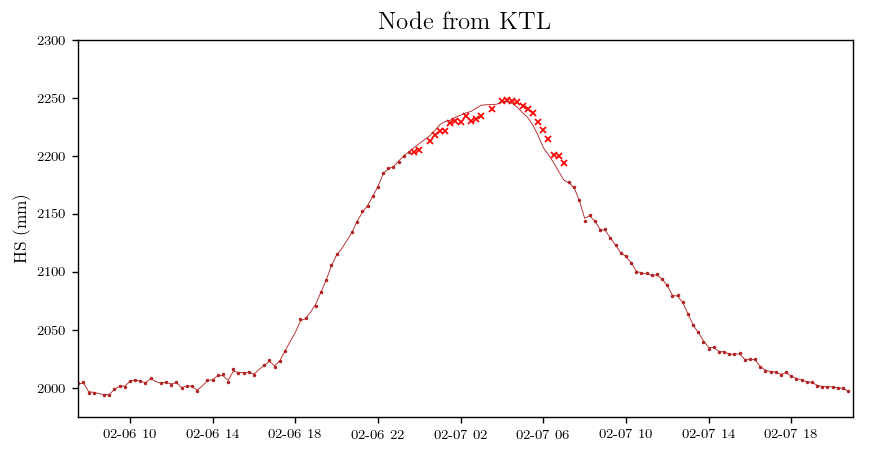

In [231]:
plt.figure(figsize=(8, 4))

plt.plot(times[ti+65:tf-(150-95)], Y[4, 65:95], 'x', markersize=3.0, color="r")

for s, c in zip([0, 4], colors):
    plt.plot(times[ti:tf], Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(times[ti:tf], Y_nand[s, :], '.', markersize=2.0, color=c)

plt.xlim(times[ti], times[tf])
plt.ylabel("HS (mm)")
plt.title("Node from KTL")
plt.ylim(1975, 2300)

plt.savefig("../presentations/figures/em_ssm_missing_data.pdf", bbox_inches='tight')

# De-fluttering summer data

In [232]:
sensors = [6]

ti, tf = 29060, 30000
Y = np.vstack((y_sd_raw[ti:tf, sensors].T, y_rad_raw[ti:tf].reshape(-1, 1).T))

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

In [233]:
n_LF = 2
max_it = 50

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)

Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)

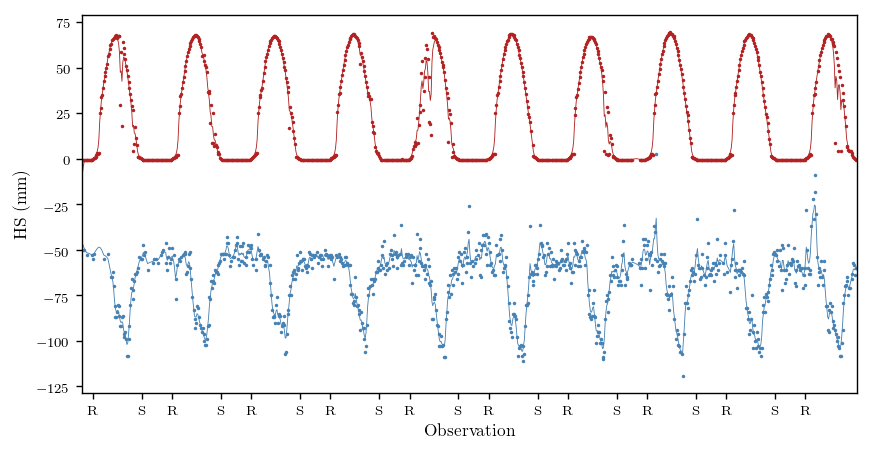

In [234]:
plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)*2), colors):
    plt.plot(times[ti:tf], Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(times[ti:tf], Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(times[ti], times[tf])
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

# Tick x axis at dawn and dusk each day
dawns, dusks = get_dawn_dusk(times[ti:tf:96])
dawn_dusk_ticks = np.array(zip(dawns, dusks)).flatten()
plt.xticks(dawn_dusk_ticks[:-1], ["R", "S"] * (len(dawn_dusk_ticks) / 2))

plt.savefig("../presentations/figures/summer_deflutter.pdf")

# Regressing summer "snow depth" onto $\sum_t {P_{\rm solar}}_t$

In [307]:
# Choose a sensor
sensor = 6

# Select summer data
ti, tf = 29060, 30000
hs = y_sd_raw[ti:tf, sensor]
rad = y_rad_raw[ti:tf]

# Extract HS and P_solar during the day
day_hs = [[]]
day_rad = [[]]

for t in range(tf-ti):
    # Get dawn and dusk times
    dawn, dusk = get_dawn_dusk(times[ti+t:ti+t+1])
    
    # If it's day, append to day's radiation or HS
    if dawn[0] < times[ti+t] < dusk[0]:
        day_hs[-1].append(hs[t])
        day_rad[-1].append(rad[t])
    # If it's about to become night, add a new day's list
    if times[ti+t] < dusk[0] < times[ti+t+1] and times[tf] >= city.sun(times[ti+t+1] + DateOffset(days=1))["sunrise"]:
        day_hs.append([])
        day_rad.append([])
        
day_hs = np.array(day_hs)
day_rad = np.array(day_rad)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


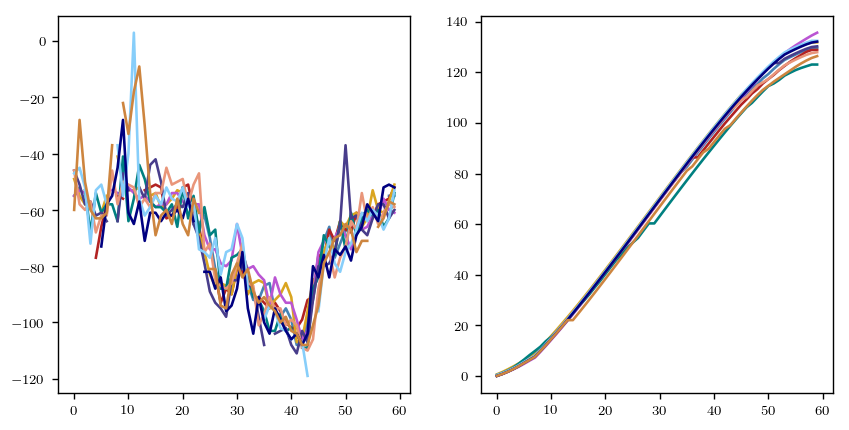

In [322]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(day_hs.T)

plt.subplot(1, 2, 2)
plt.plot(np.nancumsum(np.power(day_rad, 0.25), axis=1).T)

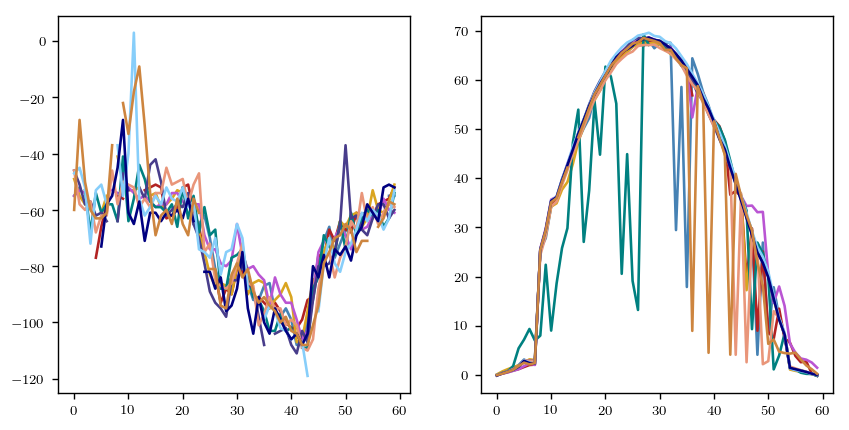

In [275]:
plt.figure(figsize=(8, 4))

for drad, dhs, c in zip(day_rad, day_hs, colors):
    plt.subplot(1, 2, 1)
    plt.plot(dhs, color=c)
    
    plt.subplot(1, 2, 2)
    plt.plot(drad, color=c)

# Scratch